In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add the src directory to the path
sys.path.append('..')

In [2]:
# Import our modules
from src.models.distilbert import load_distilbert_model, get_device
from src.data.dataset import load_and_prepare_data, prepare_batch_for_model
from src.utils.metrics import measure_performance, save_metrics, print_metrics

In [4]:
# Model configuration
MODEL_NAME = "distilbert-base-uncased"
NUM_LABELS = 2  # Binary classification

# Dataset configuration
DATASET_NAME = "glue"
DATASET_CONFIG = "sst2"  # Stanford Sentiment Treebank
BATCH_SIZE = 16
MAX_LENGTH = 128

# Output path
OUTPUT_DIR = Path("../outputs")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# Device
DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: cpu


In [5]:
# Load model and tokenizer
print(f"Loading pre-trained {MODEL_NAME} model...")
model, tokenizer = load_distilbert_model(MODEL_NAME, NUM_LABELS)

# Load and prepare dataset
print("Loading dataset and preparing data loaders...")
tokenizer, train_dataloader, eval_dataloader = load_and_prepare_data(
    tokenizer, 
    dataset_name=DATASET_NAME, 
    dataset_config=DATASET_CONFIG,
    batch_size=BATCH_SIZE, 
    max_length=MAX_LENGTH
)

Loading pre-trained distilbert-base-uncased model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading dataset and preparing data loaders...


In [6]:
# Define function to prepare batch for our specific use case
def prepare_batch(batch, device):
    return prepare_batch_for_model(batch, device)

# Measure baseline performance
print("Measuring baseline performance...")
baseline_metrics = measure_performance(model, eval_dataloader, DEVICE, prepare_batch)

# Print results
print_metrics(
    baseline_metrics, 
    model_name=MODEL_NAME, 
    dataset_info=f"Text Classification - {DATASET_NAME}/{DATASET_CONFIG}"
)

# Save metrics
save_metrics(baseline_metrics, file_path=OUTPUT_DIR / "baseline_metrics.pt")

Measuring baseline performance...

Model: distilbert-base-uncased
Task: Text Classification - glue/sst2
Number of parameters: 66,955,010
Model size: 255.41 MB
Average inference latency: 202.79 ms
Accuracy: 0.4908
Metrics saved to ../outputs/baseline_metrics.pt


In [7]:
# Print model architecture
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [8]:
# Analyze parameter distribution
param_sizes = {name: param.numel() for name, param in model.named_parameters()}
total_params = sum(param_sizes.values())

# Sort by size
sorted_params = sorted(param_sizes.items(), key=lambda x: x[1], reverse=True)

# Print the largest layers
print("Top 10 largest layers by parameter count:")
for name, count in sorted_params[:10]:
    print(f"{name}: {count:,} parameters ({count/total_params*100:.2f}% of total)")

Top 10 largest layers by parameter count:
distilbert.embeddings.word_embeddings.weight: 23,440,896 parameters (35.01% of total)
distilbert.transformer.layer.0.ffn.lin1.weight: 2,359,296 parameters (3.52% of total)
distilbert.transformer.layer.0.ffn.lin2.weight: 2,359,296 parameters (3.52% of total)
distilbert.transformer.layer.1.ffn.lin1.weight: 2,359,296 parameters (3.52% of total)
distilbert.transformer.layer.1.ffn.lin2.weight: 2,359,296 parameters (3.52% of total)
distilbert.transformer.layer.2.ffn.lin1.weight: 2,359,296 parameters (3.52% of total)
distilbert.transformer.layer.2.ffn.lin2.weight: 2,359,296 parameters (3.52% of total)
distilbert.transformer.layer.3.ffn.lin1.weight: 2,359,296 parameters (3.52% of total)
distilbert.transformer.layer.3.ffn.lin2.weight: 2,359,296 parameters (3.52% of total)
distilbert.transformer.layer.4.ffn.lin1.weight: 2,359,296 parameters (3.52% of total)


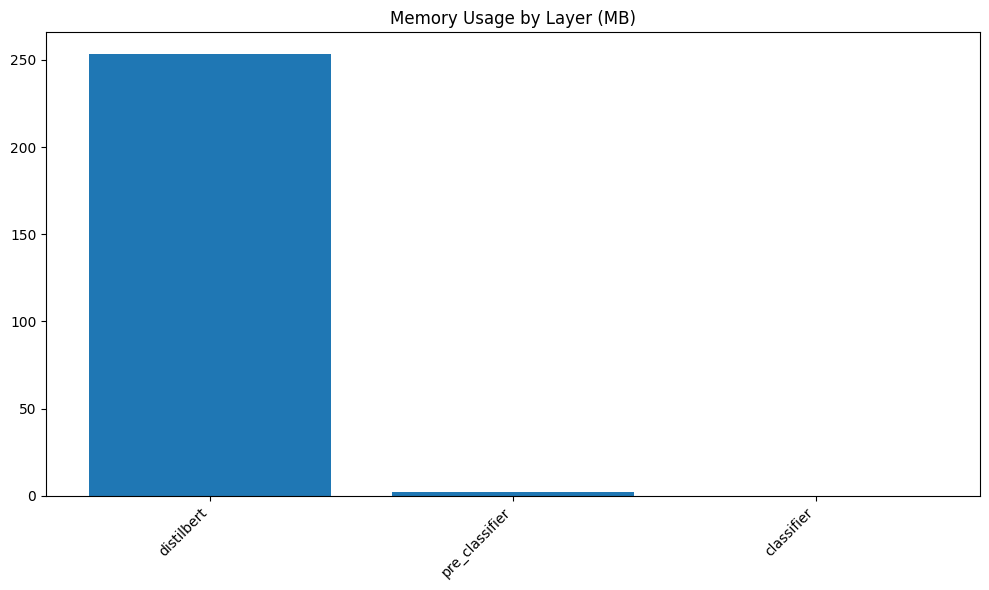

distilbert: 253.15 MB (66,362,880 parameters)
pre_classifier: 2.25 MB (590,592 parameters)
classifier: 0.01 MB (1,538 parameters)


In [9]:
# Group parameters by layer
layer_params = {}
for name, param in model.named_parameters():
    layer_name = name.split('.')[0] if '.' in name else name
    if layer_name not in layer_params:
        layer_params[layer_name] = 0
    layer_params[layer_name] += param.numel()

# Calculate sizes in MB
layer_sizes_mb = {layer: params * 4 / (1024 * 1024) for layer, params in layer_params.items()}

# Plot layer sizes
plt.figure(figsize=(10, 6))
plt.bar(layer_sizes_mb.keys(), layer_sizes_mb.values())
plt.title('Memory Usage by Layer (MB)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print layer statistics
for layer, size in sorted(layer_sizes_mb.items(), key=lambda x: x[1], reverse=True):
    print(f"{layer}: {size:.2f} MB ({layer_params[layer]:,} parameters)")

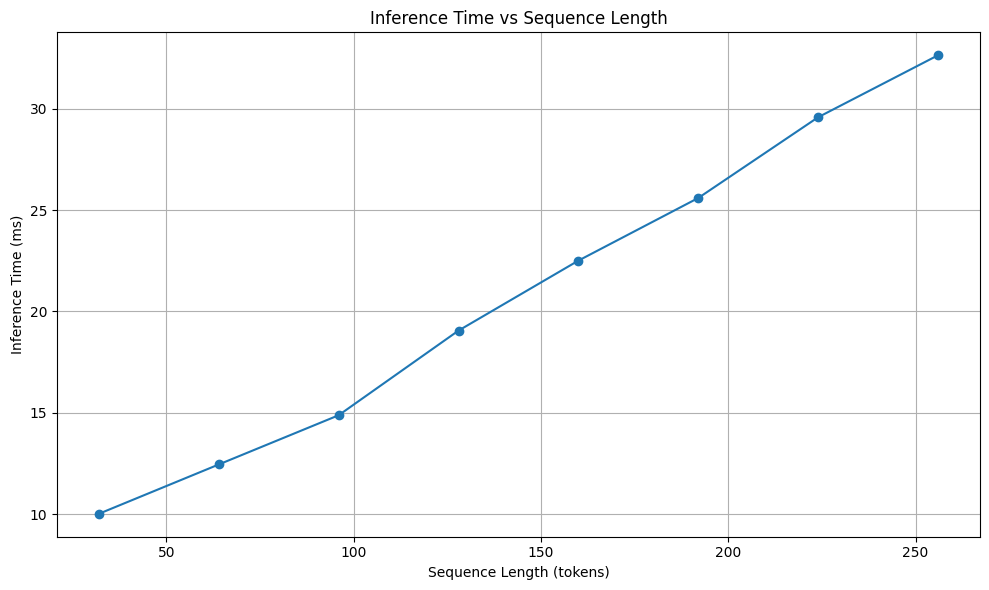

In [10]:
import time

# Function to measure inference time for different sequence lengths
def measure_inference_by_length(model, tokenizer, device, max_length=512, step=32):
    model.to(device)
    model.eval()
    
    sequence_lengths = list(range(step, max_length + 1, step))
    latencies = []
    
    # Sample text (repeated to create longer sequences)
    base_text = "This is a sample text for inference time measurement. "
    
    with torch.no_grad():
        for length in sequence_lengths:
            # Create text of appropriate length
            text = base_text * (length // len(base_text) + 1)
            text = text[:length]
            
            # Tokenize
            inputs = tokenizer(text, return_tensors="pt", padding="max_length", 
                              max_length=length, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Measure inference time (average of 5 runs)
            times = []
            for _ in range(5):
                start_time = time.time()
                _ = model(**inputs)
                times.append(time.time() - start_time)
            
            latencies.append(sum(times) / len(times) * 1000)  # Convert to ms
    
    return sequence_lengths, latencies

# Measure inference time by sequence length
lengths, latencies = measure_inference_by_length(model, tokenizer, DEVICE, max_length=256)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(lengths, latencies, 'o-')
plt.title('Inference Time vs Sequence Length')
plt.xlabel('Sequence Length (tokens)')
plt.ylabel('Inference Time (ms)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Function to measure memory usage for different batch sizes
def measure_memory_by_batch(model, tokenizer, device, max_batch=32, sequence_length=128):
    if not torch.cuda.is_available():
        print("CUDA not available, skipping memory measurement")
        return [], []
    
    model.to(device)
    model.eval()
    
    batch_sizes = [2**i for i in range(6) if 2**i <= max_batch]  # Powers of 2 up to max_batch
    memory_usage = []
    
    # Sample text
    base_text = "This is a sample text for memory usage measurement. "
    text = base_text * (sequence_length // len(base_text) + 1)
    text = text[:sequence_length]
    
    with torch.no_grad():
        for batch_size in batch_sizes:
            # Reset memory stats
            torch.cuda.reset_peak_memory_stats(device)
            
            # Create batch
            texts = [text] * batch_size
            inputs = tokenizer(texts, return_tensors="pt", padding="max_length", 
                              max_length=sequence_length, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Run inference
            _ = model(**inputs)
            
            # Measure memory
            memory_mb = torch.cuda.max_memory_allocated(device) / (1024 * 1024)
            memory_usage.append(memory_mb)
    
    return batch_sizes, memory_usage

# Measure memory usage by batch size
if torch.cuda.is_available():
    batch_sizes, memory_usages = measure_memory_by_batch(model, tokenizer, DEVICE)
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(batch_sizes, memory_usages, 'o-')
    plt.title('Memory Usage vs Batch Size')
    plt.xlabel('Batch Size')
    plt.ylabel('GPU Memory Usage (MB)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("CUDA not available, skipping memory analysis")

CUDA not available, skipping memory analysis


In [12]:
# Summary
print("=== DistilBERT Baseline Summary ===")
print(f"Model size: {baseline_metrics['model_size_mb']:.2f} MB")
print(f"Number of parameters: {baseline_metrics['num_parameters']:,}")
print(f"Inference latency: {baseline_metrics['avg_latency_ms']:.2f} ms")
print(f"Accuracy: {baseline_metrics['accuracy']:.4f}")
print("\nOptimization Targets:")
print(f"- Target model size (50% reduction): {baseline_metrics['model_size_mb'] * 0.5:.2f} MB")
print(f"- Target accuracy (90% of baseline): {baseline_metrics['accuracy'] * 0.9:.4f}")
print("\nNext steps will explore optimization techniques including:")
print("1. Pruning: Remove less important weights")
print("2. Quantization: Reduce precision of weights and activations")
print("3. Inference optimization: Optimize model for inference speed")

=== DistilBERT Baseline Summary ===
Model size: 255.41 MB
Number of parameters: 66,955,010
Inference latency: 202.79 ms
Accuracy: 0.4908

Optimization Targets:
- Target model size (50% reduction): 127.71 MB
- Target accuracy (90% of baseline): 0.4417

Next steps will explore optimization techniques including:
1. Pruning: Remove less important weights
2. Quantization: Reduce precision of weights and activations
3. Inference optimization: Optimize model for inference speed
